In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import joblib
import json
from datetime import datetime
import seaborn as sns


In [ ]:
df = pd.read_csv("../data/processed/taiwan_credit_model_data.csv")
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,MAX_PAST_DELAY,TOTAL_PAY_AMT,BILL_AMT_TOTAL,UTILISATION,PAYMENT_TO_BILL_RATIO,PAY_AMT_STD,DEFAULT
0,20000,2,2,1,24,2,689,7704,0.385200,0.089422,281.283072,1
1,120000,2,2,2,26,2,5000,17077,0.142308,0.292774,752.772653,1
2,90000,2,2,2,34,0,11018,101653,1.129478,0.108387,1569.815488,0
3,50000,2,2,1,37,0,8388,231334,4.626680,0.036259,478.058155,0
4,50000,1,2,1,57,0,59049,109339,2.186780,0.540049,13786.230736,0


In [4]:
print(df.shape)
print(df["DEFAULT"].value_counts(normalize=True)) # class imbalance

(30000, 12)
DEFAULT
0    0.7788
1    0.2212
Name: proportion, dtype: float64


In [5]:
X = df.drop("DEFAULT", axis=1)
y = df["DEFAULT"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=77, stratify=y) #test size 30% due to class imbalance
cat_features = ["SEX", "EDUCATION", "MARRIAGE"]
num_features = ["LIMIT_BAL","AGE","MAX_PAST_DELAY","BILL_AMT_TOTAL","TOTAL_PAY_AMT","UTILISATION","PAYMENT_TO_BILL_RATIO","PAY_AMT_STD"]


In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(drop='first'), cat_features)
    ])

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
logistic_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state= 77,
        penalty="l2"))
])


In [8]:
logistic_model.fit(X_train, y_train)

C:\Users\cheng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [9]:
y_prob = logistic_model.predict_proba(X_test)[:, 1]
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_prob)
print(f"Test AUC: {auc:.4f}")

Test AUC: 0.7391


In [33]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)
cv_auc_scores = cross_val_score(logistic_model, X, y, cv=cv, scoring='roc_auc')
print(f"Cross-validation AUC: {cv_auc_scores.mean():.4f} ± {cv_auc_scores.std():.4f}")

C:\Users\cheng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
C:\Users\cheng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
C:\Users\cheng

Cross-validation AUC: 0.7357 ± 0.0054


C:\Users\cheng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


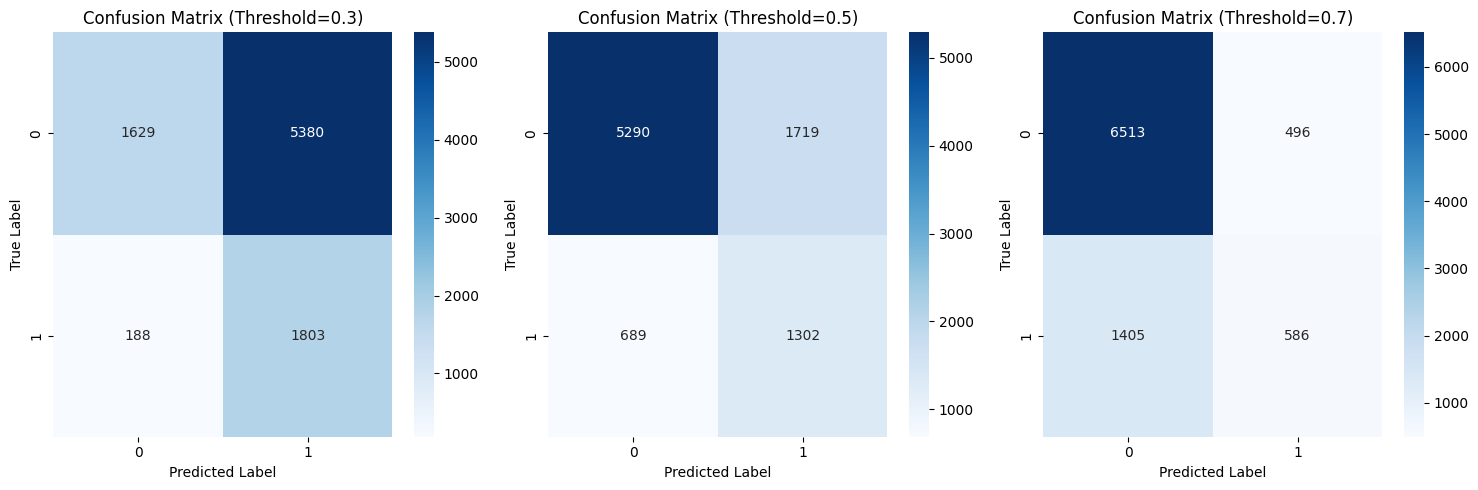

In [43]:
from sklearn.metrics import confusion_matrix
threshold = [0.3,0.5,0.7]
fig, axes = plt.subplots(1, len(threshold), figsize=(15,5))
for ax, t in zip(axes, threshold):
    y_pred = (y_prob >= t).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix (Threshold={t})')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
plt.tight_layout()
plt.show()

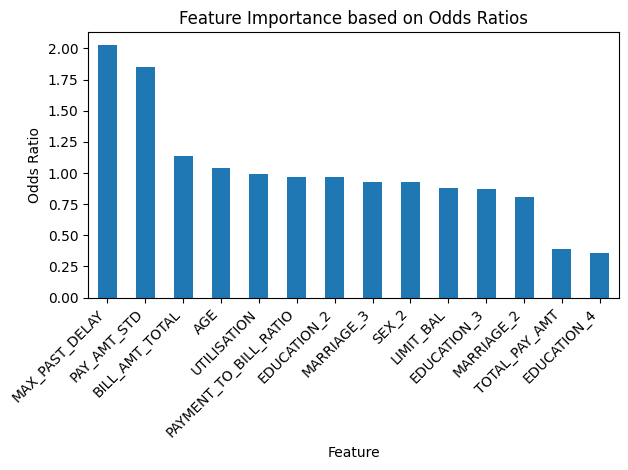

In [16]:
ohe = logistic_model.named_steps["preprocessor"].named_transformers_["cat"]
cat_features_ohe = ohe.get_feature_names_out(["SEX", "EDUCATION", "MARRIAGE"])
feature_names = num_features + list(cat_features_ohe)
coefficients = logistic_model.named_steps["classifier"].coef_[0]
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients,
    "Odds_Ratio": np.exp(coefficients)
})
coef_df = coef_df.sort_values("Coefficient", ascending=False)
coef_df.plot.bar(x="Feature", y="Odds_Ratio", legend=False)
plt.ylabel("Odds Ratio")
plt.title("Feature Importance based on Odds Ratios")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Coefficient analysis indicates that repayment behaviour is the primary driver of default risk. Maximum past delinquency and payment volatility exhibit the strongest positive associations with default, while higher credit limits and stronger repayment effort substantially reduce risk. Demographic variables display comparatively small effects, suggesting that behavioural and financial factors dominate model predictions

In [17]:
# smote
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
smote_model = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=77)),
    ("classifier", LogisticRegression(
        max_iter=1000,
        random_state= 77,
        penalty="l2"))
])

In [18]:
smote_model.fit(X_train, y_train)

C:\Users\cheng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The

In [19]:
y_prob_smote = smote_model.predict_proba(X_test)[:, 1]
roc_auc_smote = roc_auc_score(y_test, y_prob_smote)
print(f"Test AUC with SMOTE: {roc_auc_smote:.4f}")


Test AUC with SMOTE: 0.7402


SMOTE marginally increased the test ROC-AUC from 0.739 to 0.740, which is negligible. This means class-weighted logistic regression sufficiently addressed class imbalance, baseline model is retained for simplicity and interpretability

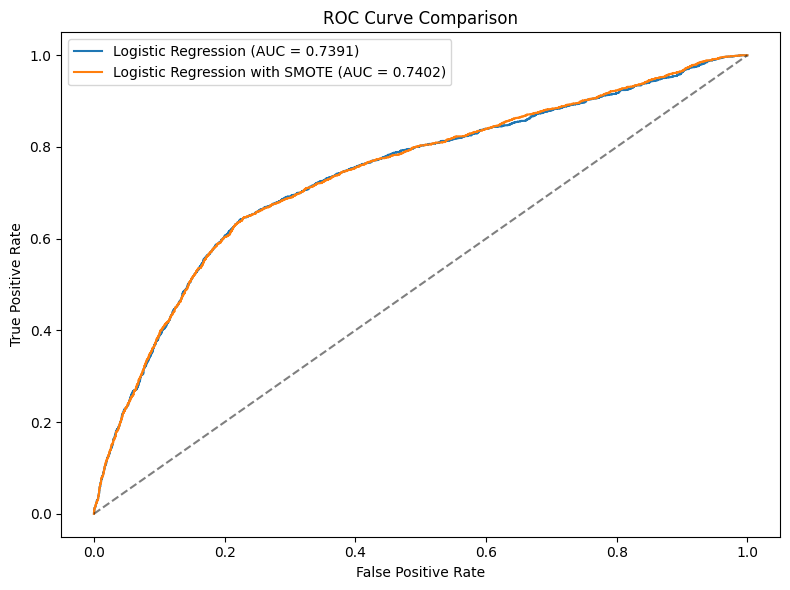

In [22]:
# ROC curve comparison to confirm
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc_base = auc(fpr, tpr)
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_prob_smote)
roc_auc_smote = auc(fpr_smote, tpr_smote)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc_base:.4f})')
plt.plot(fpr_smote, tpr_smote,
         label=f'Logistic Regression with SMOTE (AUC = {roc_auc_smote:.4f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# random forest
from sklearn.ensemble import RandomForestClassifier
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=300, # stable auc after 300 trees
        max_depth=None, # allow interactions
        n_jobs=-1, 
        min_samples_leaf=50, # prevent overfitting
        random_state=77))
])


In [24]:
rf_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [25]:
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
print(f"Test AUC with Random Forest: {roc_auc_rf:.4f}")

Test AUC with Random Forest: 0.7715


random forest performs better than logistic regression, this is because there are meaningful non-linearities and interactions in data that logistic regression cannot capture

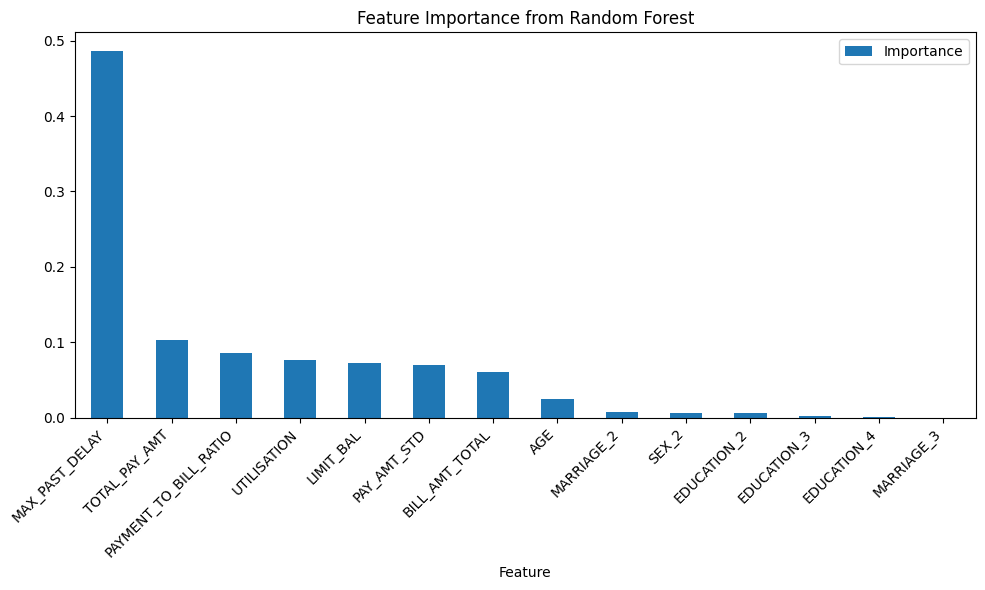

In [26]:
# feature importance
rf_classifier = rf_model.named_steps["classifier"]
ohe = rf_model.named_steps["preprocessor"].named_transformers_["cat"]
cat_features_ohe = ohe.get_feature_names_out(cat_features)
feature_names = num_features + list(cat_features_ohe)
importances = rf_classifier.feature_importances_
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})
importance_df = importance_df.sort_values("Importance", ascending=False)
importance_df.plot(x="Feature", y="Importance", kind="bar", figsize=(10, 6))
plt.title("Feature Importance from Random Forest")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [28]:
# xgboost
from xgboost import XGBClassifier
xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=300,
        max_depth=4, # prevent overfitting
        learning_rate=0.05, # slow learning for stable optimisation
        subsample=0.8, # row sampling
        colsample_bytree=0.8, # feature sampling
        eval_metric="auc", # use AUC for evaluation metric
        n_jobs=-1, 
        random_state=77))
])

In [29]:
xgb_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [30]:
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print(f"Test AUC with XGBoost: {roc_auc_xgb:.4f}")

Test AUC with XGBoost: 0.7728


In [35]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)
cv_auc = cross_val_score(xgb_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"XGBoost Cross-validation ROC–AUC: {cv_auc.mean():.4f} ± {cv_auc.std():.4f}")


XGBoost Cross-validation ROC–AUC: 0.7676 ± 0.0065


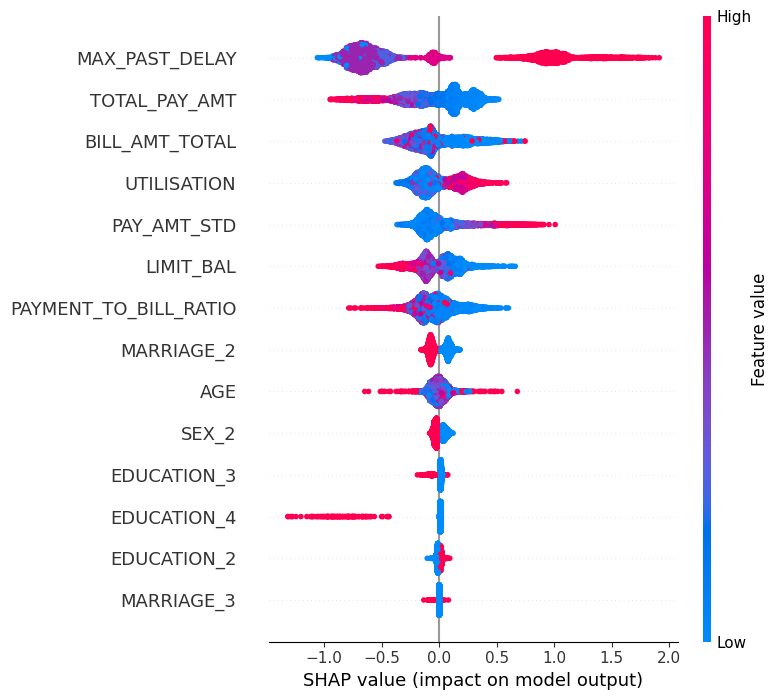

In [31]:
xgb_classifier = xgb_model.named_steps["classifier"]
X_test_transformed = xgb_model.named_steps["preprocessor"].transform(X_test)
explainer = shap.Explainer(xgb_classifier)
shap_values = explainer(X_test_transformed)
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, show = True)

Default risk is driven mainly by repayment behaviour and delinquency severity. Higher past delinquency and payment volatility increase predicted risk, while higher repayment amounts/ratios and higher credit limits reduce risk. Demographic variables have minimal impact once behavioural and financial features are included.

In [27]:
# save full pipelines
joblib.dump(logistic_model, "logistic_pipeline.joblib")
joblib.dump(rf_model, "rf_pipeline.joblib")
joblib.dump(xgb_model, "xgb_pipeline.joblib")
# save feature lists + scores for reproducibility
metadata = {
    "saved_at": datetime.now().isoformat(timespec="seconds"),
    "cat_features": cat_features,
    "num_features": num_features,
    "auc": {
        "logistic": float(roc_auc_base),
        "smote_logistic": float(roc_auc_smote),
        "random_forest": float(roc_auc_rf),
        "xgboost": float(roc_auc_xgb),
    }
}
with open("model_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)
print("Saved: logistic_pipeline.joblib, rf_pipeline.joblib, xgb_pipeline.joblib, model_metadata.json")

Saved: logistic_pipeline.joblib, rf_pipeline.joblib, xgb_pipeline.joblib, model_metadata.json
